In [1]:
from pyspark.sql import SparkSession

path_to_jar = "/home/jovyan/work/data/jars/postgresql-42.3.2.jar"

spark = SparkSession.builder.master("local") \
    .appName("Analysis") \
    .config("spark.jars", path_to_jar) \
    .getOrCreate()

sc = spark.sparkContext

1. Reading data from Postgres

In [2]:
df_stats = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_stats")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats.limit(10).toPandas().head(5)

,RK,Name,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,flag
0,1,Joel Embiid PHI,C,51,33.099998,29.5,9.3,19.000000,49.000000,1.3,...,82.199997,11.2,4.4,1.1,1.4,3.0,31,2,31.420000,Season_Regular_2021_22
1,2,Giannis Antetokounmpo MIL,PF,53,32.799999,29.4,10.0,18.500000,54.299999,1.1,...,72.400002,11.6,6.0,1.0,1.4,3.3,35,4,32.160000,Season_Regular_2021_22
2,3,LeBron James LAL,SF,46,36.799999,29.4,11.1,21.200001,52.200001,2.8,...,76.400002,8.1,6.2,1.5,1.0,3.4,18,4,26.510000,Season_Regular_2021_22
3,4,DeMar DeRozan CHI,SF,60,35.900002,28.1,10.3,20.200001,51.200001,0.7,...,86.599998,5.3,5.1,0.9,0.3,2.4,5,0,24.340000,Season_Regular_2021_22
4,5,Trae Young ATL,PG,58,34.599998,28.0,9.4,20.500000,45.700001,2.9,...,89.699997,3.8,9.3,0.9,0.1,4.0,31,0,25.280001,Season_Regular_2021_22


## 2. Select last 3 season data



In [84]:
from pyspark.sql.functions import col

seasons = ["Season_Regular_2021_22", "Season_Regular_2020_21", "Season_Regular_2019_20", "Season_Regular_2018_19", "Season_Regular_2017_18"]
df_stats_last_three = df_stats.where(col('flag').isin(seasons)).toPandas()

df_stats_last_three["Name"] = df_stats_last_three["Name"].str.split(" ").str[:-1]
df_stats_last_three["Name"] = df_stats_last_three["Name"].str.join(" ")
df_stats_last_three['POS'] = df_stats_last_three['POS'].map({'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5, 'G': 6, 'F': 7})
df_stats_last_three = df_stats_last_three.groupby(by='Name').mean().round(2)
df_stats_last_three = df_stats_last_three.reset_index(drop=False)

# reject players with less than 400 min in season
df_stats_last_three = df_stats_last_three[(df_stats_last_three['GP']*df_stats_last_three['MIN']) > 400]

df_stats_last_three.head(5)

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FTA,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER
1,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,3.30,69.739998,6.88,3.08,0.78,0.66,1.82,12.6,0.4,15.36
3,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,1.12,82.599998,1.68,2.30,0.62,0.22,1.05,1.0,0.0,11.29
5,Aaron Nesmith,382.0,3.0,46.0,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.60,78.599998,2.80,0.50,0.30,0.20,0.50,0.0,0.0,9.46
6,Abdel Nader,352.5,3.0,47.0,13.22,5.00,1.78,4.05,42.950001,0.68,...,1.02,71.750000,1.95,0.58,0.35,0.30,0.68,0.0,0.0,9.69
10,Al Horford,112.8,5.0,58.0,29.50,12.56,5.06,10.64,47.480000,1.44,...,1.32,80.459999,7.06,3.94,0.76,1.12,1.30,8.8,0.2,17.50


In [85]:
drop = ["RK", "Name", "POS", "GP", "MIN","TO","PER"]
stats_train = df_stats_last_three.drop(columns=drop)
stats_train.head()

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
1,14.98,5.62,12.32,46.000000,1.44,4.22,33.160000,2.28,3.30,69.739998,6.88,3.08,0.78,0.66,12.6,0.4
3,7.25,2.68,6.42,41.950001,0.95,2.55,37.150002,0.90,1.12,82.599998,1.68,2.30,0.62,0.22,1.0,0.0
5,4.70,1.70,3.90,43.799999,0.90,2.30,37.000000,0.50,0.60,78.599998,2.80,0.50,0.30,0.20,0.0,0.0
6,5.00,1.78,4.05,42.950001,0.68,1.78,36.700001,0.75,1.02,71.750000,1.95,0.58,0.35,0.30,0.0,0.0
10,12.56,5.06,10.64,47.480000,1.44,3.94,36.419998,1.02,1.32,80.459999,7.06,3.94,0.76,1.12,8.8,0.2


In [86]:
#skalowanie danych
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stats_scaled=pd.DataFrame(scaler.fit_transform(stats_train))
stats_scaled.columns=stats_train.columns
stats_scaled.head(5)

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,0.474964,0.516807,0.555440,0.396752,0.300000,0.365368,0.6632,0.271429,0.330579,0.567714,0.476003,0.313725,0.367568,0.264,0.255061,0.017544
1,0.198498,0.207983,0.249741,0.302784,0.197917,0.220779,0.7430,0.107143,0.105372,0.751429,0.066876,0.228758,0.281081,0.088,0.020243,0.000000
2,0.107296,0.105042,0.119171,0.345708,0.187500,0.199134,0.7400,0.059524,0.051653,0.694286,0.154996,0.032680,0.108108,0.080,0.000000,0.000000
3,0.118026,0.113445,0.126943,0.325986,0.141667,0.154113,0.7340,0.089286,0.095041,0.596429,0.088120,0.041394,0.135135,0.120,0.000000,0.000000
4,0.388412,0.457983,0.468394,0.431090,0.300000,0.341126,0.7284,0.121429,0.126033,0.720857,0.490165,0.407407,0.356757,0.448,0.178138,0.008772


In [87]:
from sklearn.decomposition import PCA
n_components=stats_train.shape[1]
pca = PCA(n_components=n_components, random_state=123)
pca.fit(stats_scaled)

PCA(n_components=16, random_state=123)

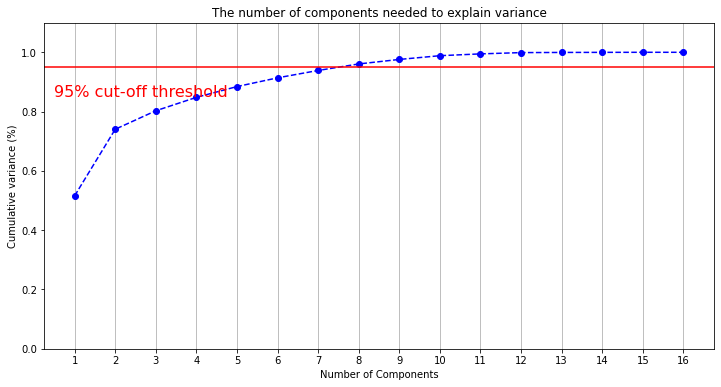

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 17, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 17, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [89]:
import numpy as np

explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

cum_explained_variance_ratio

lst = []
for i in range (0, n_components):
    lst.append([i+1, round(explained_variance_ratio[i],6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']
pca_predictor

,Component,Explained Variance,Cumulative Explained Variance
0,1,0.515932,0.515932
1,2,0.224491,0.740423
2,3,0.062367,0.802790
3,4,0.045236,0.848026
4,5,0.036339,0.884365
5,6,0.029492,0.913857
6,7,0.024884,0.938741
7,8,0.021930,0.960671
8,9,0.015219,0.975889
9,10,0.012604,0.988493


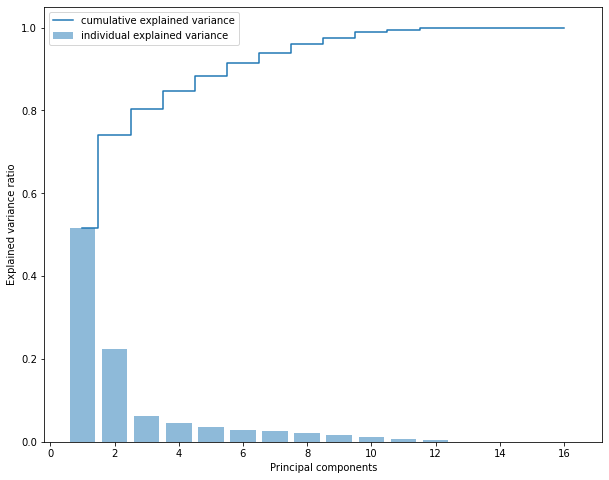

In [90]:
plt.subplots(figsize=(10,8))

plt.bar(pca_predictor['Component'],pca_predictor['Explained Variance'], align='center', alpha=0.5, 
       label='individual explained variance')
plt.step(pca_predictor['Component'],pca_predictor['Cumulative Explained Variance'], where='mid',
         label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc='best')

In [91]:
pca = PCA(n_components=7)
pca.fit(stats_scaled)


n_components = 7
pca = PCA(n_components)
dim_reduction = pca.fit_transform(stats_scaled)
reduced_df = df_stats_last_three.copy()
for i in range(n_components):
    reduced_df[f'PCA{i+1}'] = [dim_reduction[x][i] for x in range(len(dim_reduction))]

reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,DD2,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
1,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,12.6,0.4,15.36,0.476958,0.145445,-0.084277,0.060460,0.009833,0.121781,0.064184
3,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,1.0,0.0,11.29,-0.201062,-0.235526,0.050061,-0.021373,0.099248,-0.060364,-0.034575
5,Aaron Nesmith,382.0,3.0,46.0,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.0,0.0,9.46,-0.461706,-0.176381,-0.140925,0.001821,0.112899,0.005426,-0.027985
6,Abdel Nader,352.5,3.0,47.0,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.0,0.0,9.69,-0.463374,-0.133898,-0.088678,-0.005734,0.105621,0.007402,0.075639
10,Al Horford,112.8,5.0,58.0,29.50,12.56,5.06,10.64,47.480000,1.44,...,8.8,0.2,17.50,0.330034,0.094109,-0.092259,0.231074,0.035956,-0.013154,-0.085834


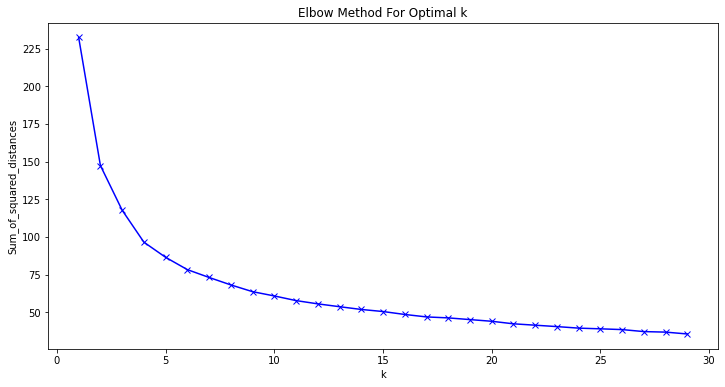

In [92]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dim_reduction)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [93]:
num_clusters = 6
kmeans = KMeans(num_clusters, random_state=42)
clusters = kmeans.fit_predict(dim_reduction)

reduced_df['Cluster'] = clusters
reduced_df = reduced_df.reset_index(drop=True)

In [94]:
reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,Cluster
0,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,0.4,15.36,0.476958,0.145445,-0.084277,0.060460,0.009833,0.121781,0.064184,2
1,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,0.0,11.29,-0.201062,-0.235526,0.050061,-0.021373,0.099248,-0.060364,-0.034575,3
2,Aaron Nesmith,382.0,3.0,46.0,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.0,9.46,-0.461706,-0.176381,-0.140925,0.001821,0.112899,0.005426,-0.027985,3
3,Abdel Nader,352.5,3.0,47.0,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.0,9.69,-0.463374,-0.133898,-0.088678,-0.005734,0.105621,0.007402,0.075639,3
4,Al Horford,112.8,5.0,58.0,29.50,12.56,5.06,10.64,47.480000,1.44,...,0.2,17.50,0.330034,0.094109,-0.092259,0.231074,0.035956,-0.013154,-0.085834,4


In [95]:
cluster_labels = kmeans.labels_
reduced_df['Cluster'] = cluster_labels

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


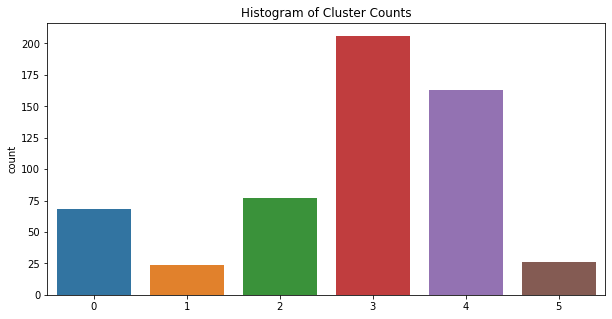

In [96]:
ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(cluster_labels)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [97]:
averages_df = reduced_df.groupby('Cluster').mean()
averages_df = averages_df.reset_index(drop=False)
averages_df = averages_df.apply(lambda x: round(x, 3))

In [98]:
df = averages_df[['PTS','FGM','FGA','FG%','3PM','3PA', '3P%', 'FTM','FTA','FT%','REB','AST','STL','BLK','DD2','TD3']]
df

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,6.469000,2.645,4.710,56.581001,0.089,0.330,13.454000,1.083,1.627,66.208000,4.825,1.023,0.457,0.697,3.820,0.017
1,24.856001,8.714,18.007,48.530998,1.979,5.469,34.844002,5.462,6.732,81.286003,7.136,5.996,1.212,0.698,22.338,3.320
2,16.629999,6.013,13.626,43.971001,2.001,5.509,35.907001,2.604,3.222,80.783997,4.682,3.863,0.966,0.413,5.472,0.329
3,5.830000,2.159,4.994,43.022999,0.738,2.157,32.917999,0.777,1.045,73.788002,2.682,1.397,0.502,0.288,0.752,0.012
4,10.126000,3.704,8.492,43.498001,1.357,3.755,35.303001,1.362,1.716,78.702003,3.625,2.403,0.819,0.377,2.193,0.075
5,14.192000,5.648,10.354,55.588001,0.417,1.262,22.427999,2.483,3.600,69.475998,9.334,2.202,0.758,1.187,24.438,0.594


Text(0, 0.5, 'value')

<Figure size 2400x720 with 0 Axes>

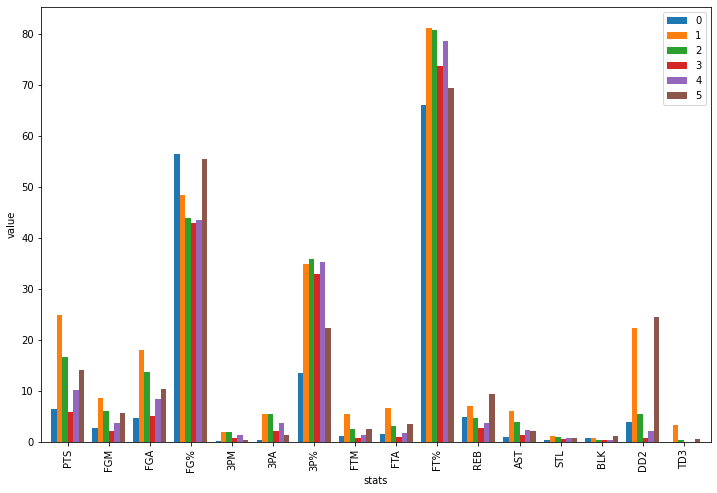

In [119]:
df_transpsed = df.transpose()

plt.figure(figsize=(20, 6), dpi=120)
df_transpsed.plot(kind="bar", figsize=(12,8), width=0.8)
# plt.title("Mince Pie Consumption Study")
plt.xlabel("stats")
plt.ylabel("value")

# Cluster 0:
    - team member - uzupełnienie składu - mało punktów, mało prób, niski procent punktów za 3, najmniej zbiórek

# Cluster 1:
    - Superstars - wysoka średnia zdobytych punktów (PTS), duży % puntktów z gry (FG%), dużo prób z gry FGA, dużo DD2, bloków, przechwytów - zawodnicy wiodący i aktywni, najwięcej TD3 (triple double)


# Cluster 2:
    - Assistant, Robin, all in 1 - dużo punktów i asyst ale nie tyle co gracze w 1 klastrze, gracze róœnież aktywni

# Cluster 3:
    - outsider - gracz rezerwowy - niskie statystki sugerujące sporadyczną grę ale też niższe umiejętności niż gracze z pozosłych klastrów

# Cluster 4:
    - Wingers - także sporo punktów, bardzo duży procent punktów za 3, sporo asyst

# Cluster 5:
   - Giants  - dużo bloków, zbiórek, przechwytów, dużo punktów, dużo DDT (double double)

In [ ]:
reduced_df.drop(columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7'], inplace=True)

In [117]:
reduced_df[reduced_df['Cluster'] == 0].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
40,Boban Marjanovic,299.75,5.0,43.50,9.550000,6.15,2.38,4.20,55.750000,0.05,...,77.800003,4.18,0.58,0.22,0.30,0.75,4.00,0.00,24.660000,0
454,Robert Williams III,285.25,5.0,41.25,17.780001,6.42,2.82,3.92,72.000000,0.00,...,64.570000,5.90,1.22,0.70,1.62,0.78,6.50,0.25,22.400000,0
95,Daniel Gafford,217.00,5.0,53.50,17.600000,8.00,3.40,4.95,68.349998,0.00,...,69.300003,5.10,0.75,0.45,1.45,0.85,4.00,0.00,21.860001,0
47,Brandon Clarke,140.67,4.0,55.67,21.870001,10.90,4.60,7.87,59.330002,0.27,...,69.699997,5.63,1.47,0.73,0.90,0.67,2.67,0.00,20.950001,0
222,JaVale McGee,231.20,5.0,62.20,15.780000,8.04,3.48,5.76,60.680000,0.02,...,67.080002,5.56,0.62,0.42,1.32,1.06,5.00,0.00,20.940001,0


In [116]:
reduced_df[reduced_df['Cluster'] == 1].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
187,Giannis Antetokounmpo,4.0,4.0,64.80,33.139999,28.320000,10.22,18.440001,55.439999,0.98,...,70.620003,11.74,5.64,1.20,1.30,3.42,45.6,4.20,30.33,1
414,Nikola Jokic,25.4,5.0,71.20,32.680000,22.059999,8.40,15.680000,53.419998,1.28,...,83.260002,11.16,7.32,1.30,0.70,3.16,49.4,13.40,27.85,1
269,Joel Embiid,8.2,5.0,56.00,31.540001,26.280001,8.60,17.559999,48.939999,1.14,...,81.220001,11.60,3.42,0.86,1.56,3.28,39.0,0.80,27.34,1
23,Anthony Davis,13.5,4.0,57.25,34.029999,25.480000,9.30,18.120001,51.119999,0.88,...,80.150002,10.08,3.12,1.48,2.22,2.20,32.0,0.25,27.24,1
237,James Harden,8.2,2.0,62.00,36.439999,29.660000,8.84,19.860001,44.520000,3.62,...,86.699997,6.88,8.98,1.62,0.74,4.50,30.2,7.40,27.24,1


In [115]:
reduced_df[reduced_df['Cluster'] == 2].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
74,Chris Paul,62.60,1.0,62.80,31.940001,16.620001,5.92,12.600000,47.080002,1.76,...,89.300003,4.80,8.48,1.72,0.26,2.34,19.60,1.0,21.660000,2
330,Kristaps Porzingis,29.33,5.0,49.33,31.700001,21.070000,7.57,16.930000,44.730000,2.23,...,81.570000,8.33,1.53,0.67,1.90,1.57,15.33,0.0,20.680000,2
309,Kemba Walker,27.50,1.0,65.25,33.000000,21.850000,7.42,17.280001,42.750000,3.08,...,86.779999,3.85,5.30,1.08,0.38,2.22,3.75,0.0,20.020000,2
142,Donovan Mitchell,15.40,2.0,65.60,33.680000,24.120001,8.62,19.500000,44.220001,2.84,...,83.480003,4.12,4.52,1.30,0.28,2.80,1.20,0.0,19.370001,2
319,Kevin Love,76.00,4.0,43.40,26.799999,15.660000,5.00,11.780000,42.400002,2.42,...,86.260002,8.90,2.36,0.50,0.24,1.74,16.20,0.0,19.150000,2


In [114]:
reduced_df[reduced_df['Cluster'] == 3].sort_values("PER",ascending=False).head()


,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
107,David West,267.00,7.0,73.00,13.70,6.80,3.00,5.20,57.099998,0.0,...,75.900002,3.30,1.90,0.60,1.00,1.10,0.0,0.0,21.010000,3
72,Chris Boucher,238.25,4.0,52.75,15.85,8.10,2.85,5.88,47.520000,0.8,...,80.150002,4.78,0.48,0.45,1.20,0.55,6.0,0.0,20.709999,3
233,Jamal Crawford,233.33,6.0,48.33,15.20,7.73,2.87,6.70,43.730000,1.1,...,58.270000,0.83,2.97,0.33,0.10,0.90,0.0,0.0,19.370001,3
554,Willie Reed,363.00,5.0,42.00,10.20,4.60,1.90,2.90,66.900002,0.0,...,58.200001,2.90,0.20,0.20,0.50,0.50,1.0,0.0,19.200001,3
436,Pau Gasol,288.00,4.0,53.50,17.75,7.00,2.55,5.60,45.250000,0.4,...,72.800003,6.30,2.40,0.25,0.75,0.95,8.5,0.5,17.830000,3


In [113]:
reduced_df[reduced_df['Cluster'] == 4].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
387,Michael Porter Jr.,117.50,3.0,58.0,23.850000,14.15,5.40,10.20,52.549999,1.95,...,81.199997,6.00,0.95,0.60,0.70,1.10,12.0,0.0,20.240000,4
41,Bobby Portis,113.60,5.0,62.0,23.860001,12.90,5.12,10.84,47.500000,1.36,...,76.120003,7.24,1.38,0.70,0.44,1.24,12.8,0.0,17.840000,4
105,Darren Collison,131.00,1.0,72.5,28.700001,11.80,4.35,8.95,48.099998,1.20,...,85.699997,2.85,5.65,1.35,0.15,1.40,6.0,0.0,17.799999,4
405,Naz Reid,162.00,5.0,66.0,17.549999,9.70,3.65,7.25,50.549999,0.80,...,71.949997,4.15,0.95,0.45,1.05,1.00,1.5,0.0,17.730000,4
129,Derrick Rose,102.25,1.0,44.0,23.920000,14.80,5.85,12.38,46.919998,0.82,...,86.580002,2.28,3.90,0.68,0.28,1.78,1.5,0.0,17.639999,4


In [112]:
reduced_df[reduced_df['Cluster'] == 5].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
399,Montrezl Harrell,90.2,5.0,69.0,23.719999,14.76,5.92,9.62,61.740002,0.02,...,66.839996,6.12,1.58,0.62,0.90,1.28,8.8,0.0,23.570000,5
462,Rudy Gobert,80.6,5.0,64.8,32.279999,14.92,5.54,8.22,67.440002,0.00,...,65.059998,13.08,1.48,0.74,2.30,1.78,46.8,0.0,23.209999,5
276,Jonas Valanciunas,75.6,5.0,63.0,26.080000,15.60,6.26,11.04,56.820000,0.48,...,78.559998,10.50,1.74,0.46,0.98,1.84,33.6,0.2,22.920000,5
199,Hassan Whiteside,135.0,5.0,55.8,22.420000,11.68,4.92,8.42,58.700001,0.02,...,60.160000,10.00,0.80,0.46,1.86,1.36,25.8,0.0,22.900000,5
77,Clint Capela,90.6,5.0,59.6,30.379999,14.06,6.16,9.78,62.320000,0.00,...,55.360001,12.74,1.12,0.74,1.72,1.24,37.6,0.2,22.850000,5


# Ciekawostki

In [56]:
from pyspark.sql.functions import mean
df = df_stats.groupBy("flag").agg(mean('3P%').alias('3P%_mean')).where(col('flag').like('Season%')).orderBy('flag').toPandas()
df.head()

,flag,3P%_mean
0,Season_Regular_2001_02,21.667352
1,Season_Regular_2002_03,21.561905
2,Season_Regular_2003_04,21.391324
3,Season_Regular_2004_05,22.028913
4,Season_Regular_2005_06,22.550885


<AxesSubplot:>

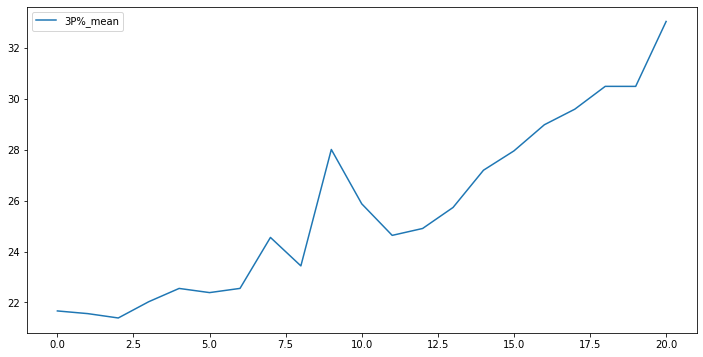

In [57]:
import matplotlib.pyplot as plt

df.plot()

In [122]:
df_stats_sal = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_salaries")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats_sal.limit(10).toPandas().head(5)

,Rank,Player,salary,current_salary_inflation,flag
0,1.,Kobe Bryant,"$24,806,250","$30,921,289",2010/11
1,2.,Rashard Lewis,"$19,573,711","$24,398,866",2010/11
2,3.,Kevin Garnett,"$18,800,000","$23,434,426",2010/11
3,4.,Tim Duncan,"$18,700,000","$23,309,775",2010/11
4,5.,Michael Redd,"$18,300,000","$22,811,170",2010/11


In [138]:
df_salaries = df_stats_sal.toPandas()

df_salaries['salary'] = df_salaries['salary'].str[1:]
df_salaries['salary'] = df_salaries['salary'].str.split(',').str.join('').astype('int')

df_sal_grouped = df_salaries.groupby(by='flag').mean()
df_sal_grouped

,salary
flag,
2000/01,3.304929e+06
2003/04,3.684160e+06
2004/05,3.773688e+06
2005/06,3.961305e+06
2007/08,4.400601e+06
2009/10,4.633963e+06
2010/11,4.413547e+06
2013/14,4.305050e+06
2017/18,5.728105e+06


<AxesSubplot:xlabel='flag'>

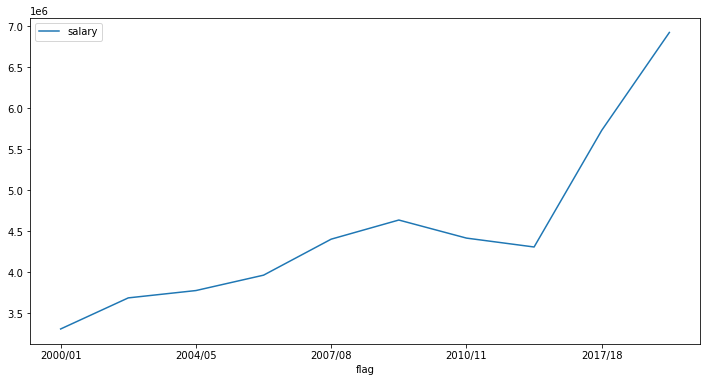

In [139]:
df_sal_grouped.plot()

In [141]:
df_stats_inj = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_injuries")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats_inj = df_stats_inj.toPandas()
df_stats_inj.head()

,PLAYER,TEAM,INJURED ON,RETURNED,DAYS MISSED,flag
0,Christian Wood,Rockets,16 Feb 22,17 Feb 22,1,Illness
1,Terry Taylor,Pacers,11 Feb 22,12 Feb 22,1,Illness
2,Jonas Valanciunas,Pelicans,28 Jan 22,31 Jan 22,3,Illness
3,Will Barton,Nuggets,28 Jan 22,30 Jan 22,2,Illness
4,Day'Ron Sharpe,Nets,26 Jan 22,28 Jan 22,2,Illness


In [149]:
df_stats_inj['year_of_inj'] = df_stats_inj['INJURED ON'].str[-3:]
df_stats_inj_count = df_stats_inj.groupby(by='year_of_inj').count()
df_stats_inj_count.head()

,PLAYER,TEAM,INJURED ON,RETURNED,DAYS MISSED,flag
year_of_inj,,,,,,
11,20,20,20,20,20,20
12,26,26,26,26,26,26
13,48,48,48,48,48,48
14,62,62,62,62,62,62
15,162,162,162,162,162,162


<AxesSubplot:xlabel='year_of_inj'>

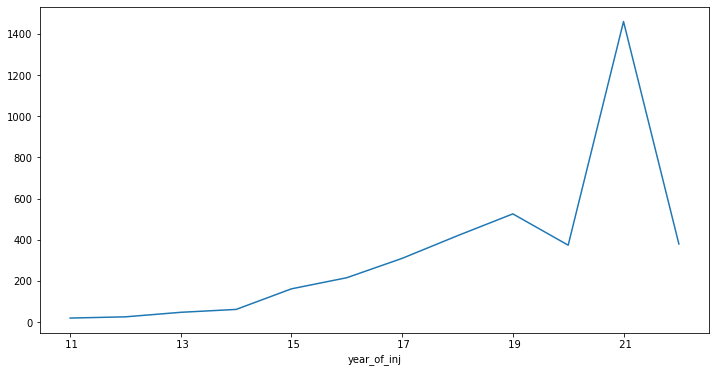

In [150]:
df_stats_inj_count['PLAYER'].plot()